## Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

## 02. A2C
[Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.](http://proceedings.mlr.press/v48/mniha16.pdf)

**Actor critic** methods are one of the popular **policy optimization** algorithms. This approach optimize the parameters for maximizing expected return by pushing up the probabilities of actions that receive higher return. Let $\pi_\theta$ denote a policy with parameters $\theta$. The policy gradient of performance $\mathcal{J}(\pi_\theta)$ is

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right]$$

where $\tau$ is a trajectory and $A^{\pi_\theta}$ is the advantage function for reducing variance of values. The **policy gradient algorithm** updates the parameters by adding this gradient.

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k})$$

where $\alpha$ is learning rate. This parameter is updated by current policy, thus the agent is trained in an on-policy way. The actor is the policy which predicts probabilities of actions in each state. And the critic predicts value functions of state-action pairs. 


## import module

In [2]:
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical, Normal

## Network
We will use two separated networks for actor and critic. The actor network consists of one fully connected layer and two streams of fully connected layer that outputs the mean and standard deviation of a normal distribution. The ReLU function is used for hidden layer. And the mean(**mu**) output layer is pass through by tanh function for outputing from -1 to 1. Pendulum-v0 has range from -2 to 2, so the output is multipied by 2. On the other hand, The critic network has only two fully connected layers. We used a ReLU activation functions for the hidden layer and Linear function for the output layer. One thing to note is that we initialize the final layer's weights and biases so that they are uniformly distributed.

In [3]:
class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialization."""
        super(Actor, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.log_std_layer = nn.Linear(128, out_dim)
        self.mu_layer = nn.Linear(128, out_dim)        
        
        self.log_std_layer.weight.data.uniform_(-init_w, init_w)
        self.log_std_layer.bias.data.uniform_(-init_w, init_w)
        
        self.mu_layer.weight.data.uniform_(-init_w, init_w)
        self.mu_layer.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        
        mu = F.tanh(self.mu_layer(x)) * 2
        
        log_std = F.softplus(self.log_std_layer(x))
        
        std = torch.exp(log_std)
        
        dist = Normal(mu, std)
        action = dist.sample()
        
        return action, dist
    
class Critic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialization."""
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)
        
        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        value = self.out(x)
        
        return value

## Agent
Here is a summary of Agent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

In [4]:
class Agent:
    def __init__(
        self,
        env: gym.Env,
        gamma: float = 0.9,        
    ):
        """Initialize
        
        Args:
            env(gym.Env): openAI Gym environment
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.env = env
        self.gamma = gamma
        
        self.weight_entropy = 1e-2
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        
        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # transition (log_prob, pred_value, next_state, reward, done)
        self.transition: list = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        
        selected_action, dist = self.actor(state)
        
        if self.is_test:
            selected_action = dist.mean
        else:
            predicted_value = self.critic(state)
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = []
            self.transition.extend([log_prob, predicted_value])
            
        return selected_action.clamp(-2, 2).cpu().detach().numpy()

    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        
        if not self.is_test:
            self.transition.extend([next_state, reward, done])
    
        return next_state, reward, done
    
    def update_model(self):
        log_prob, pred_value, next_state, reward, done = self.transition
        next_state = torch.FloatTensor(next_state).to(self.device)

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        next_value = self.critic(next_state).detach()
        q_value = reward + self.gamma * next_value * mask
        q_value = q_value.to(self.device)

        # advantage = Q_t - V(s_t)
        advantage = q_value - pred_value

        # calculate loss at the current step
        policy_loss = -advantage.detach() * log_prob  # adv. is not backpropagated
        policy_loss += self.weight_entropy * -log_prob  # entropy
        value_loss = F.smooth_l1_loss(pred_value, q_value.detach())

        # train
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        return policy_loss.item(), value_loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        '''Train the agent.'''
        self.is_test = False
        
        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        
        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            
            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            state = next_state
            score += reward
            
            # if episode ends
            if done:         
                state = env.reset()
                scores.append(score)
                score = 0                
            
            # potting
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        
        self.env.close()
    
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(30, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('actor_loss')
        plt.plot(actor_losses)
        plt.subplot(133)
        plt.title('critic_loss')
        plt.plot(critic_losses)
        plt.show()

## Environment

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [6]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)

## Set random seed

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

## Initialize

In [8]:
num_frames = 100000

agent = Agent(env)

cuda


## Train

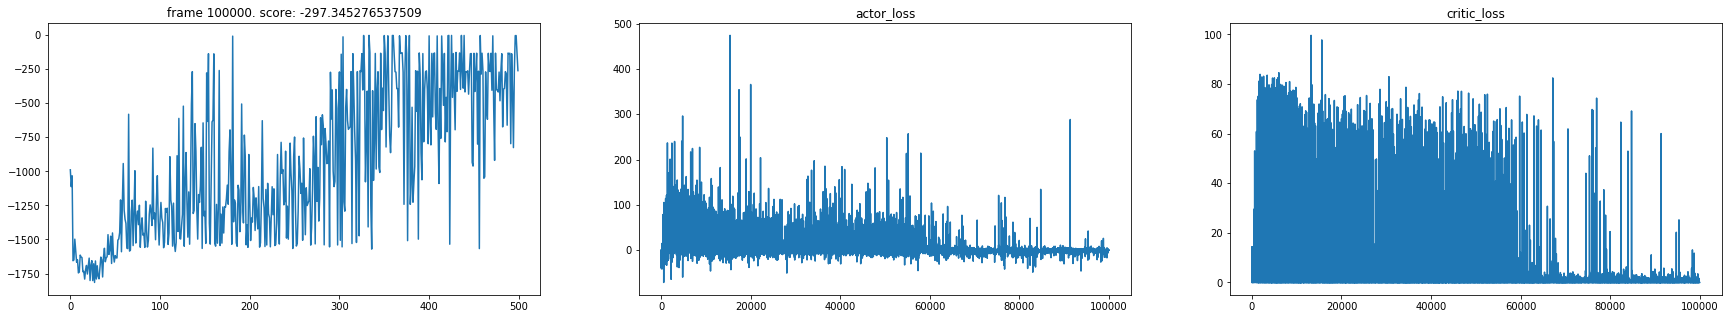

In [9]:
agent.train(num_frames)

## Test

In [10]:
frames = agent.test()

score:  -0.7219485853814335


## Render


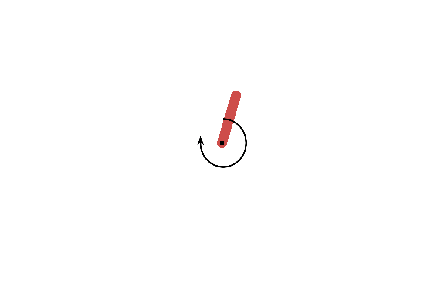
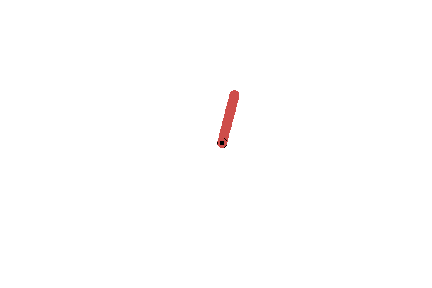
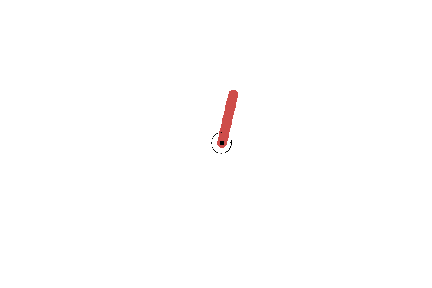
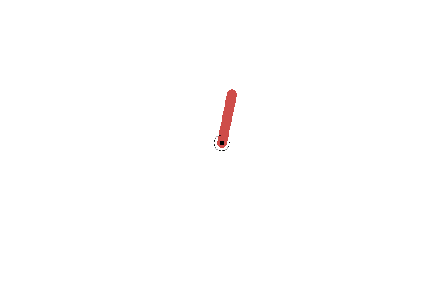
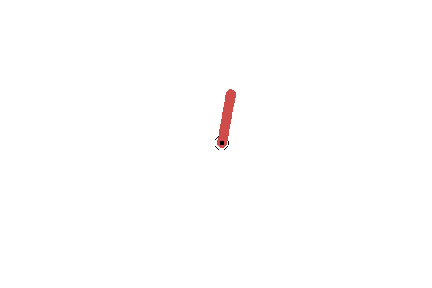
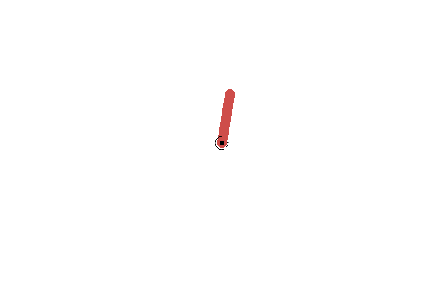
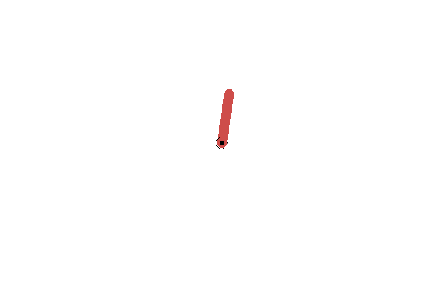
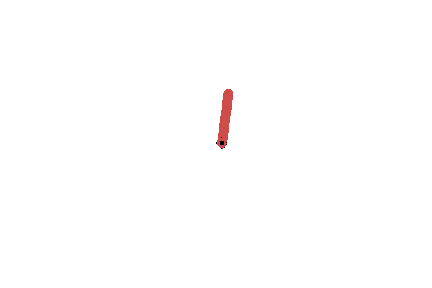
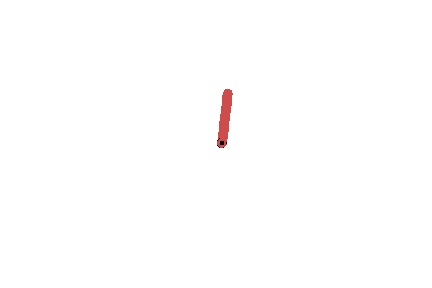
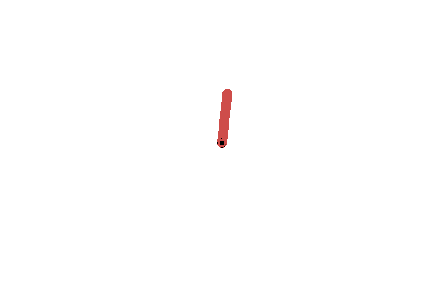
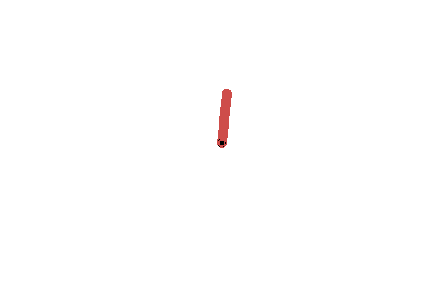
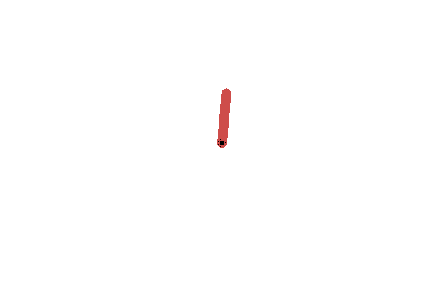
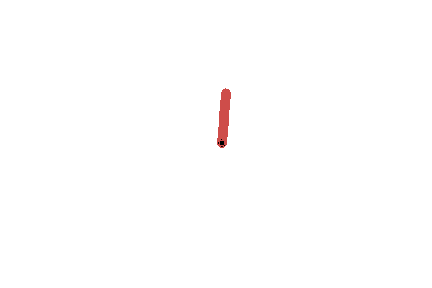
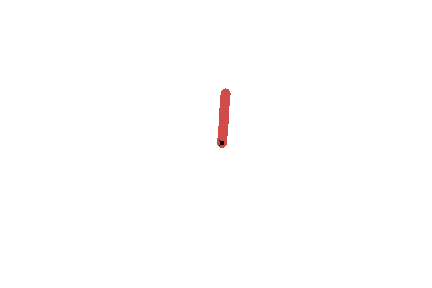
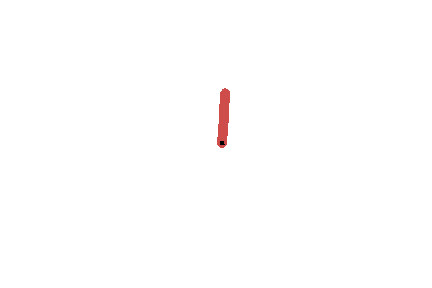
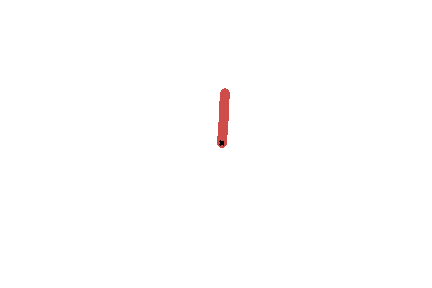
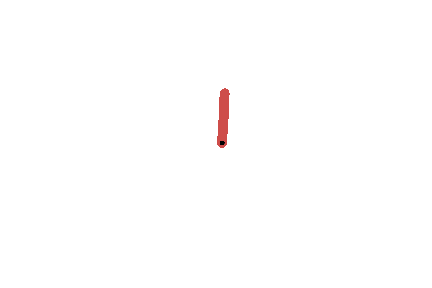
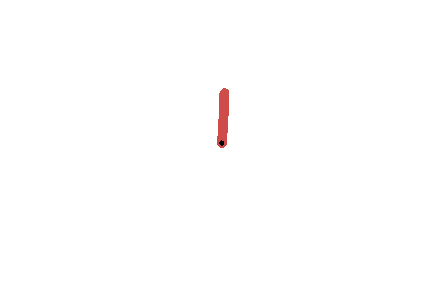
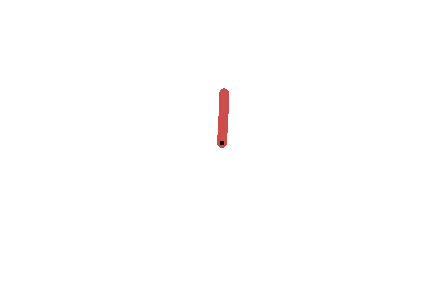
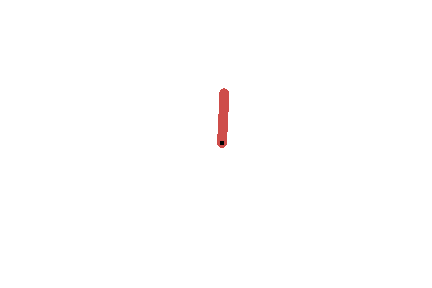
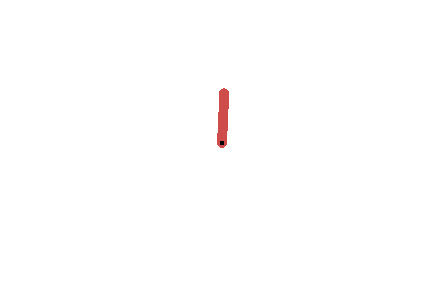
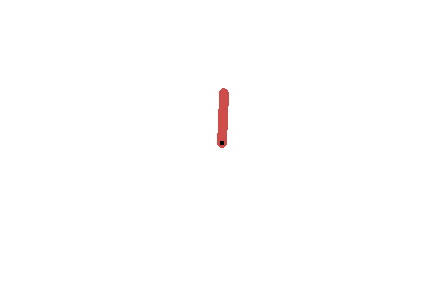
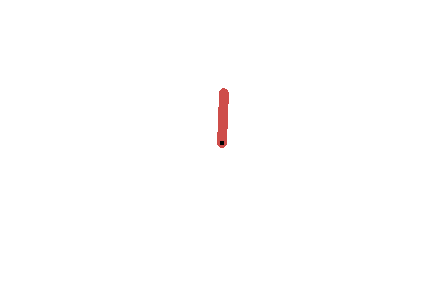
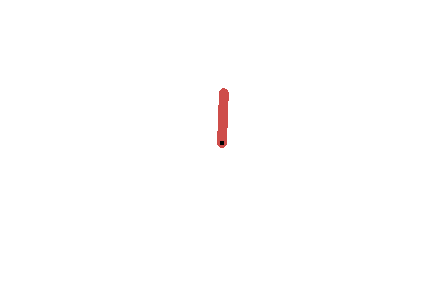
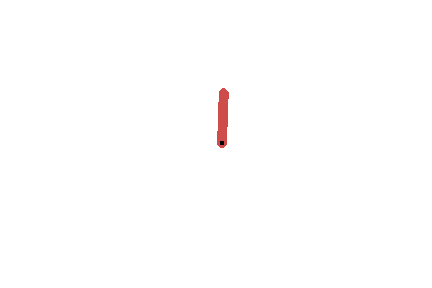
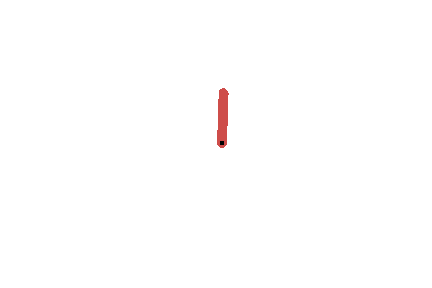
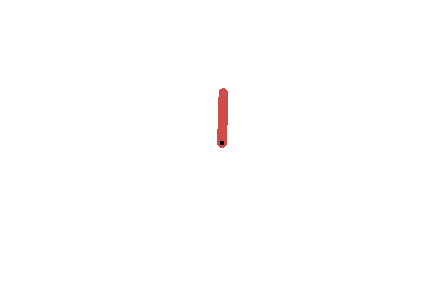
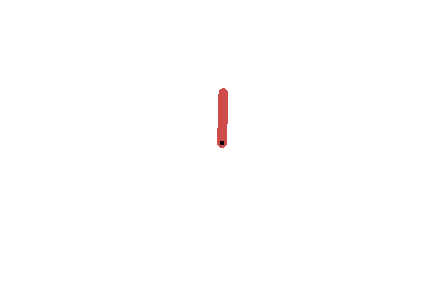
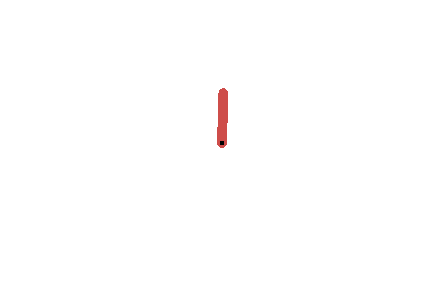
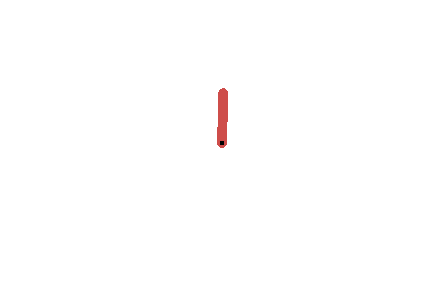
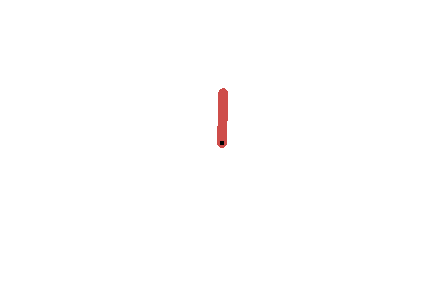
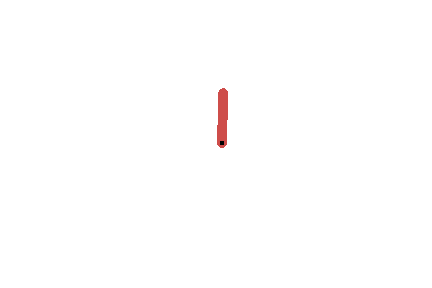
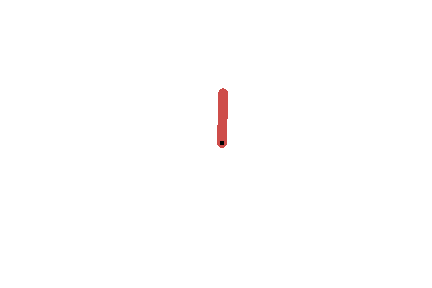
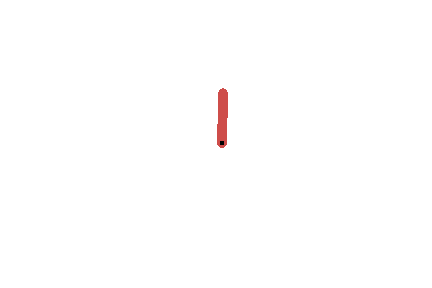
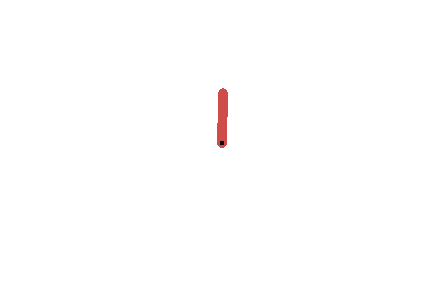
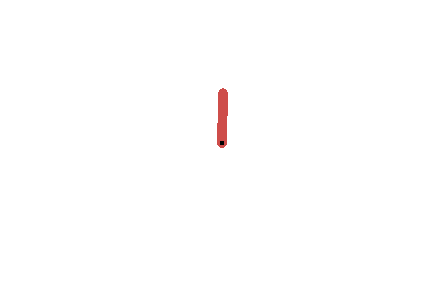
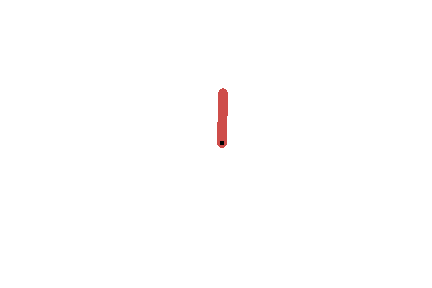
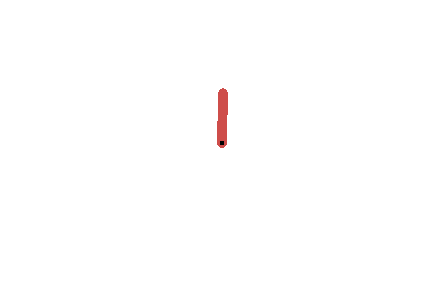
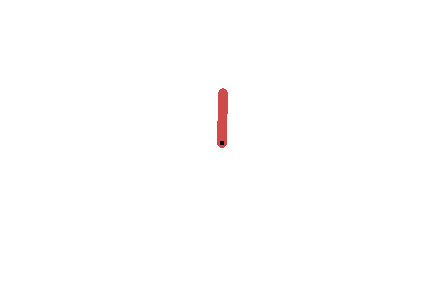
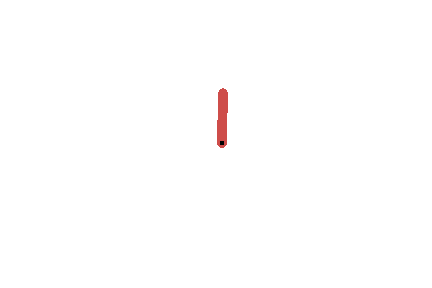
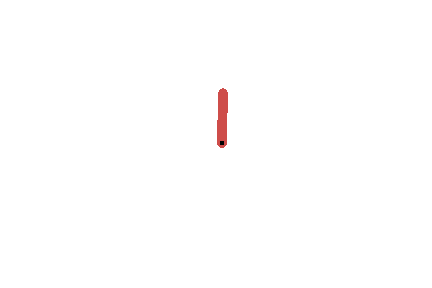
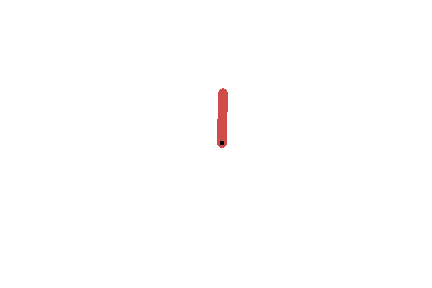
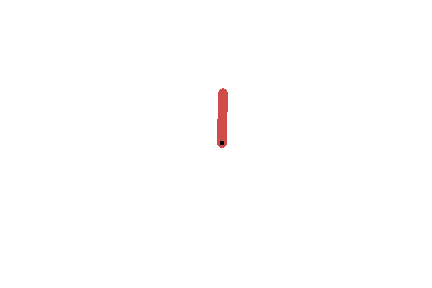
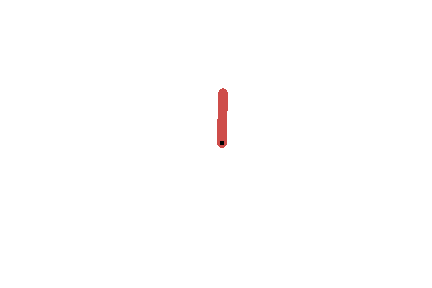
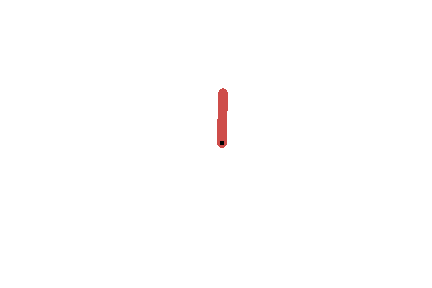
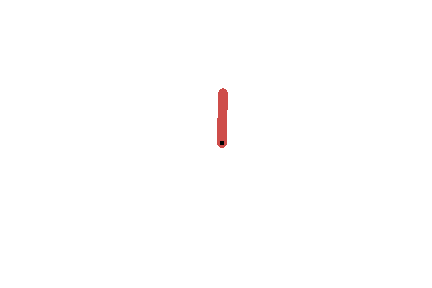
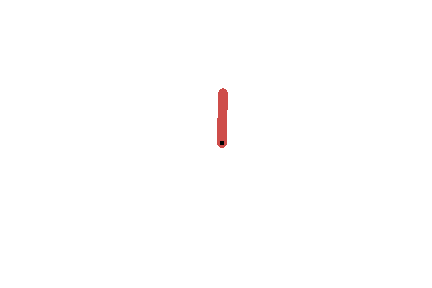
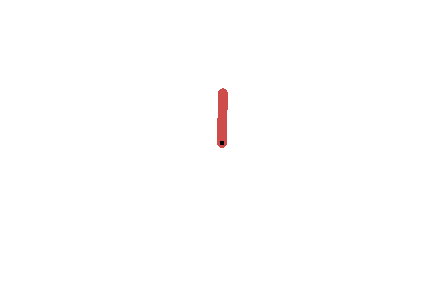
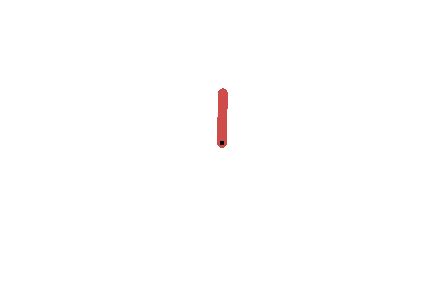
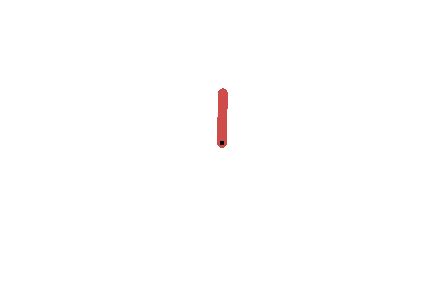
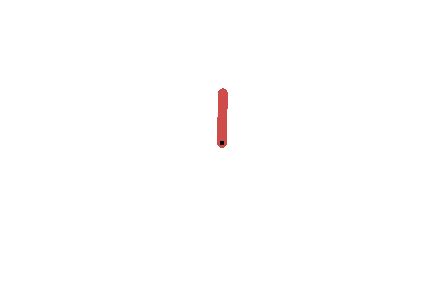
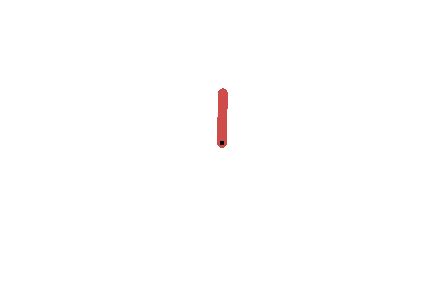
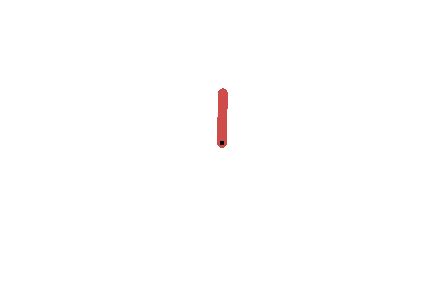
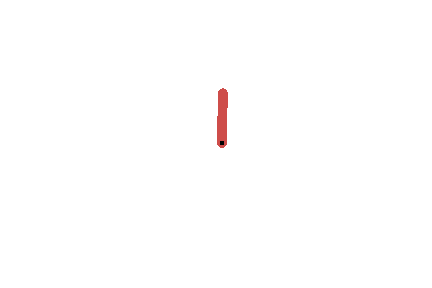
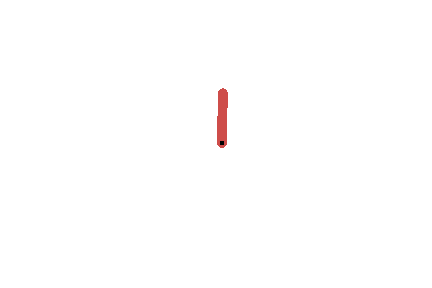
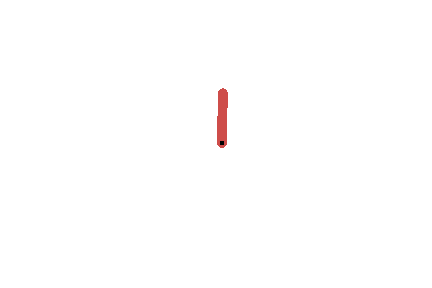
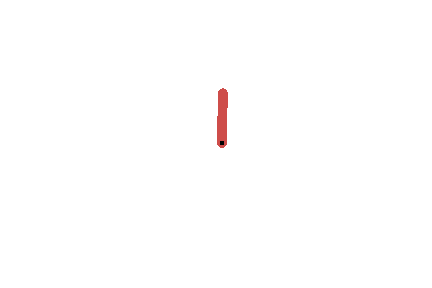
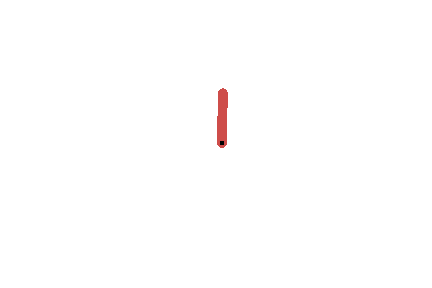
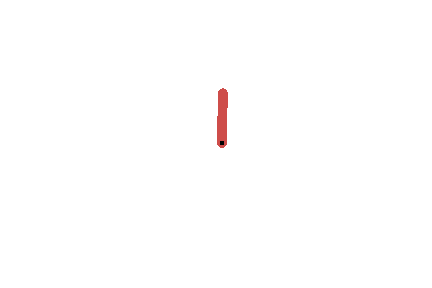
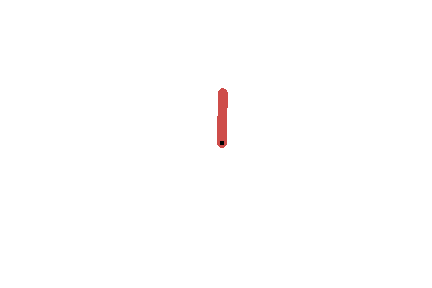
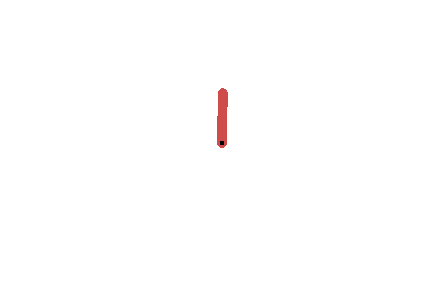
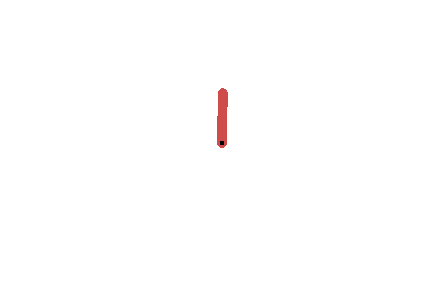
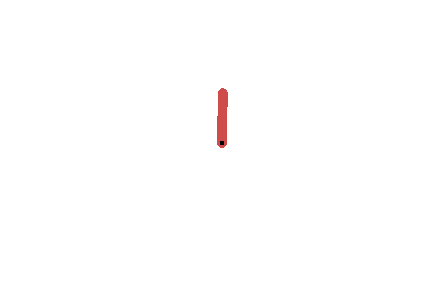
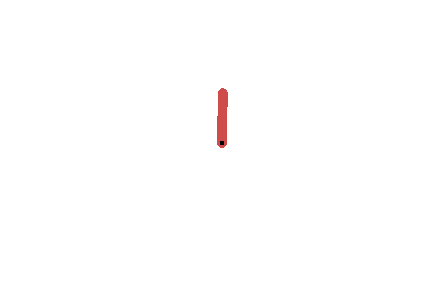
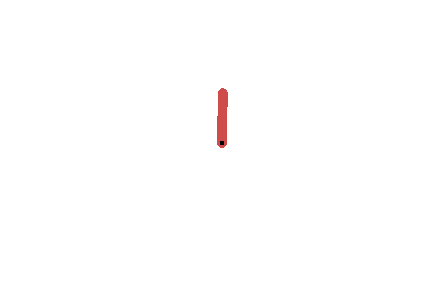
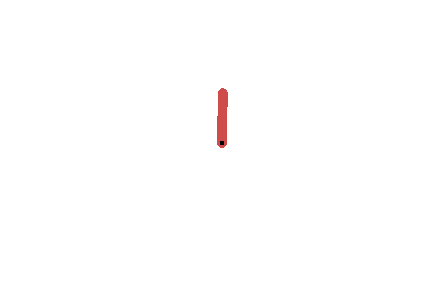
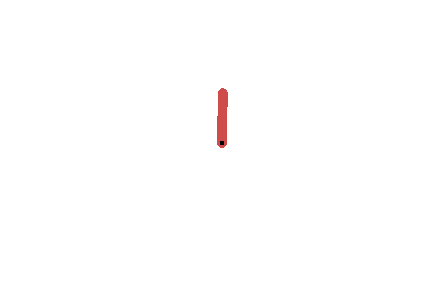
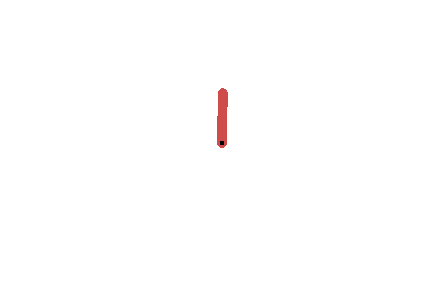
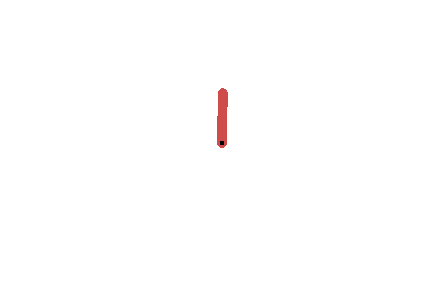
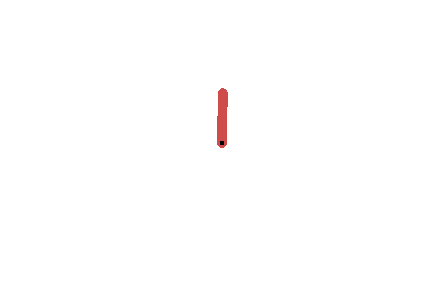
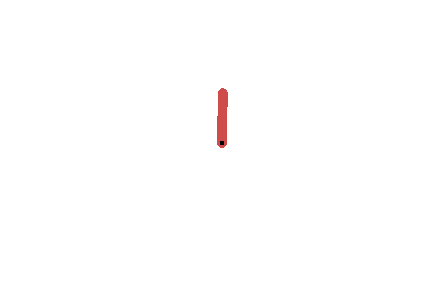
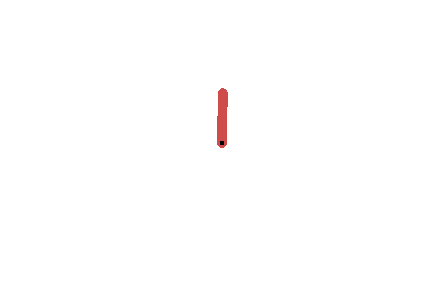
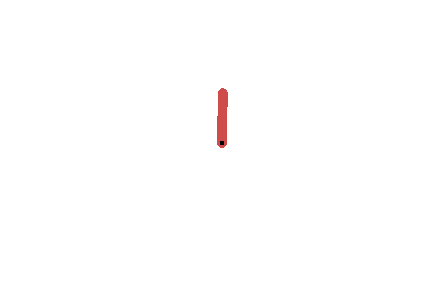
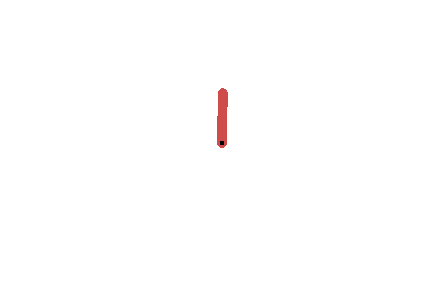
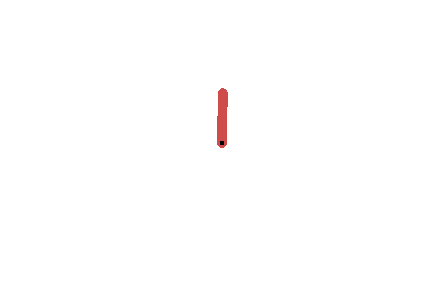
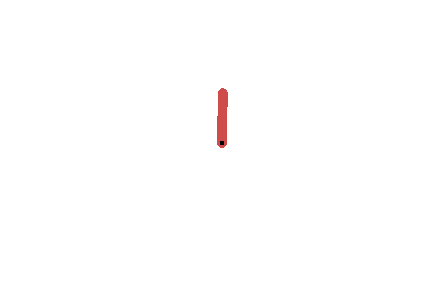
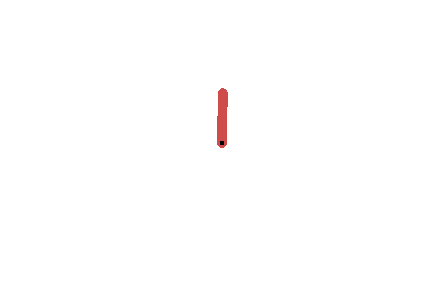
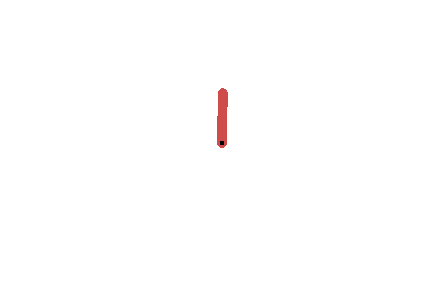
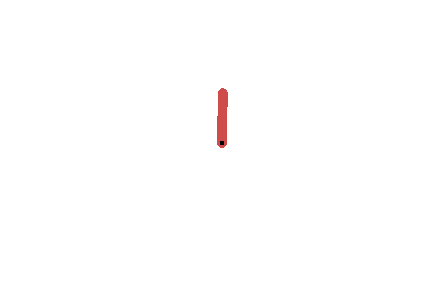
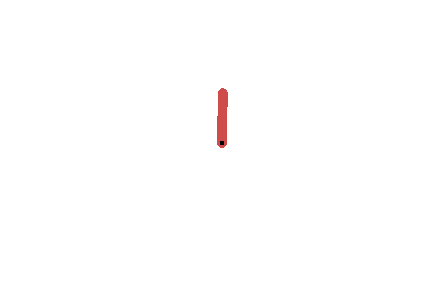
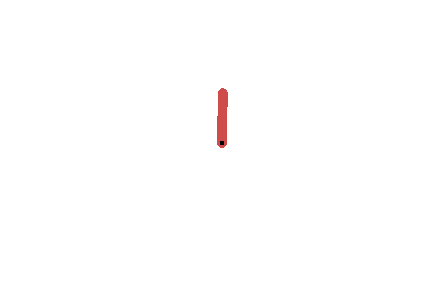
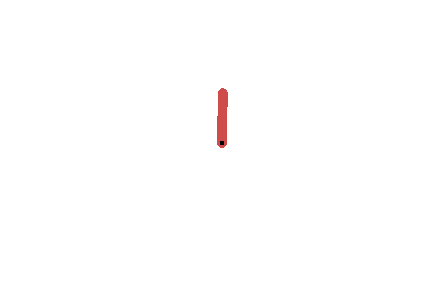
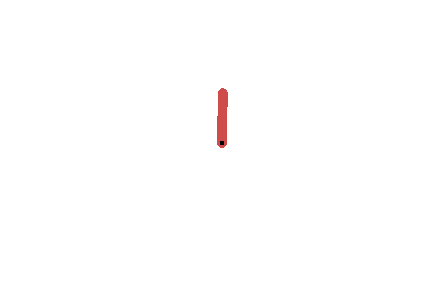
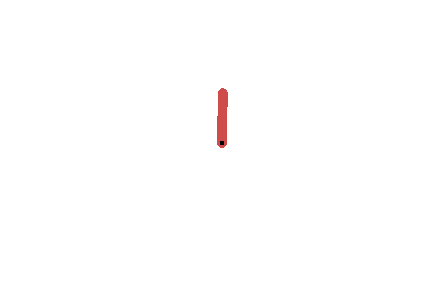
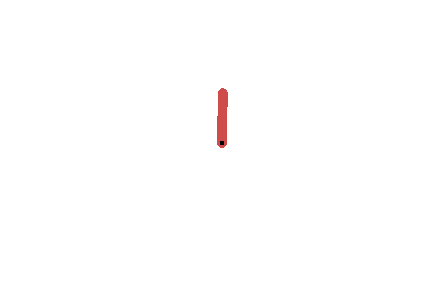
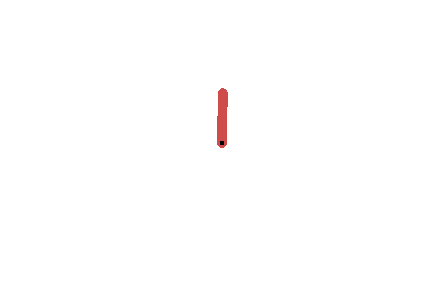
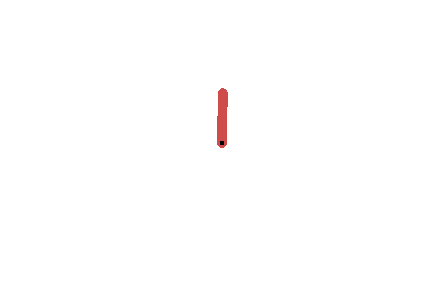
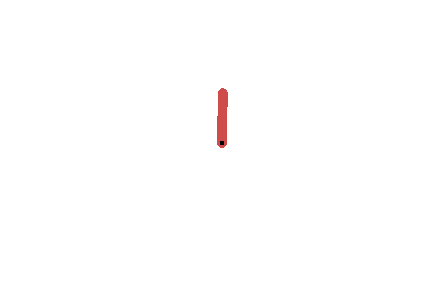
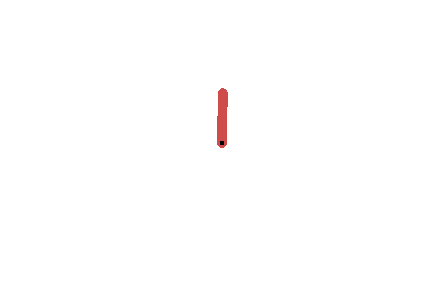
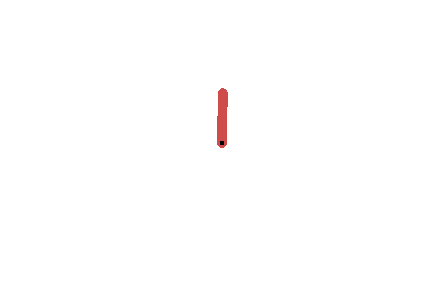
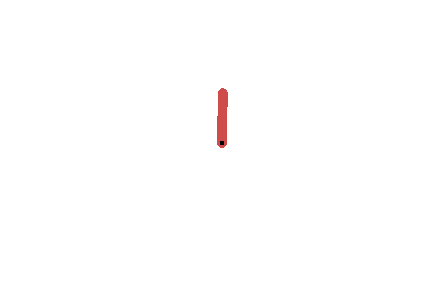
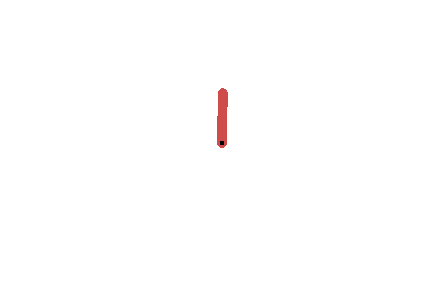
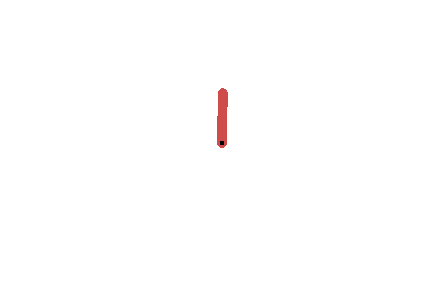
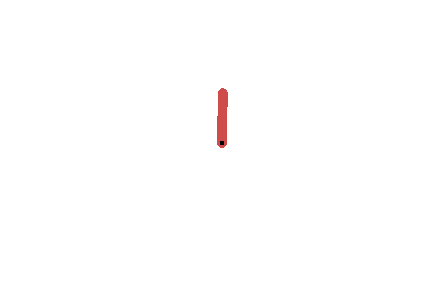
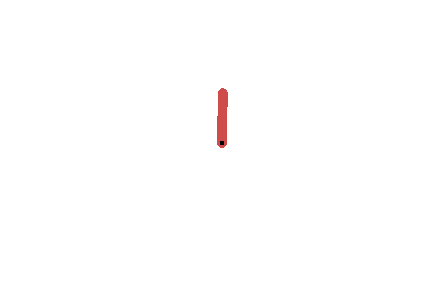
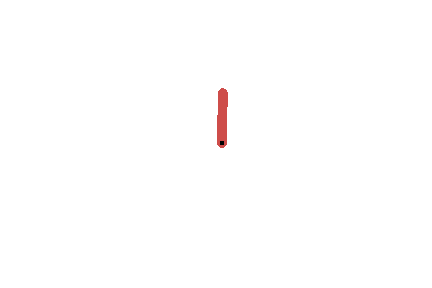
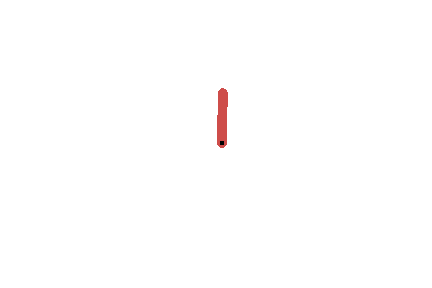
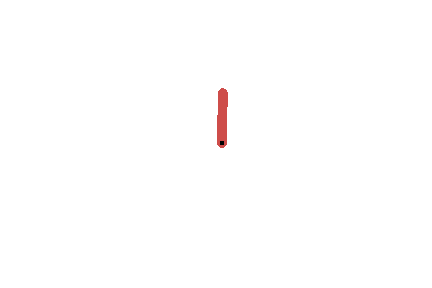
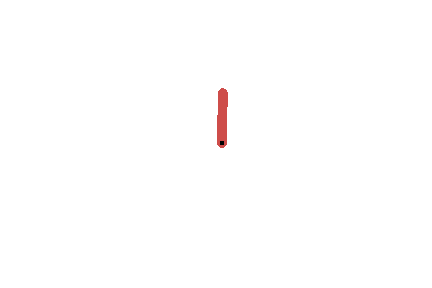
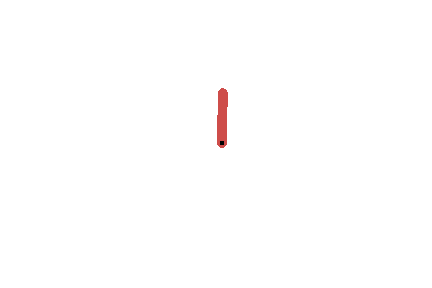
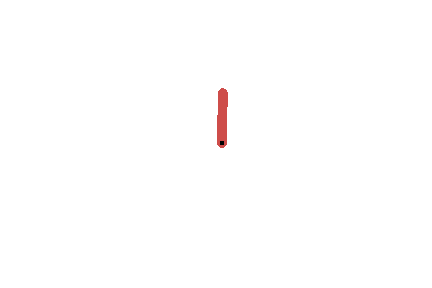
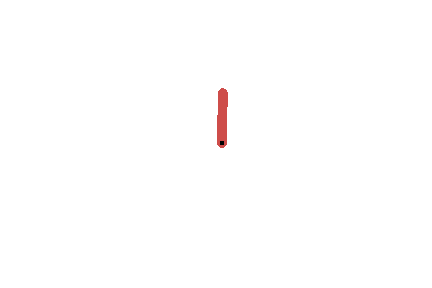
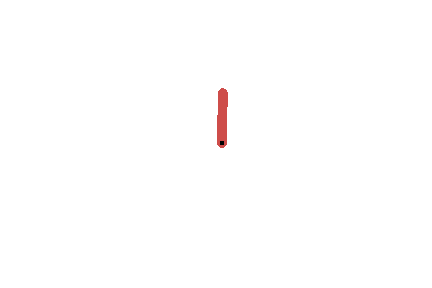
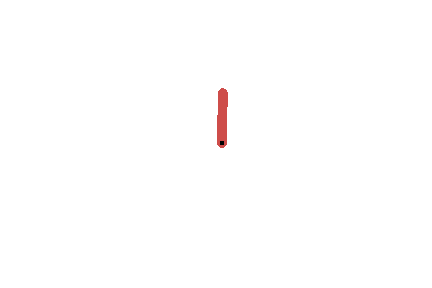
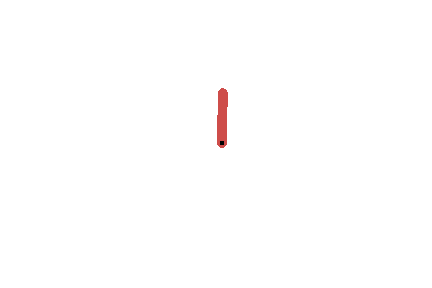
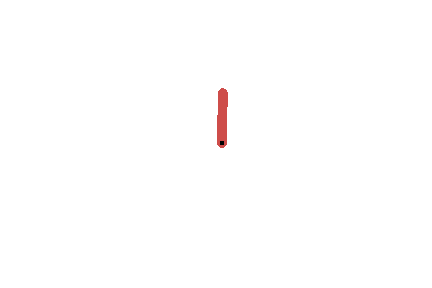
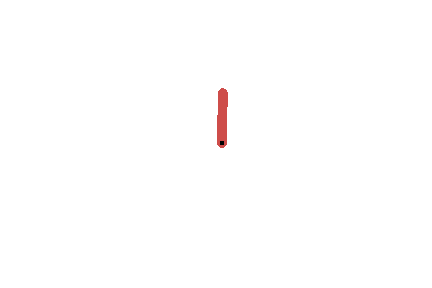
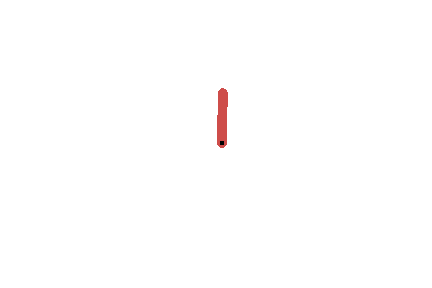
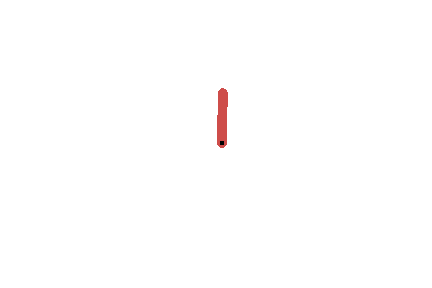
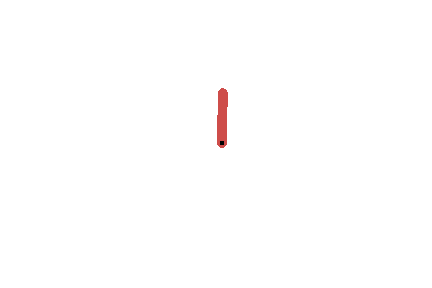
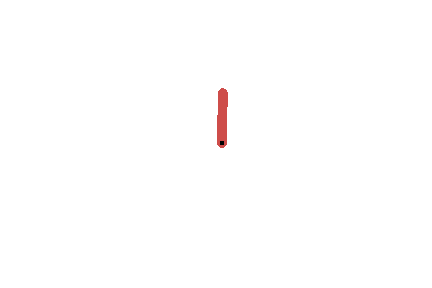
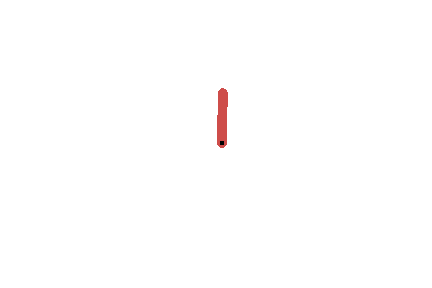
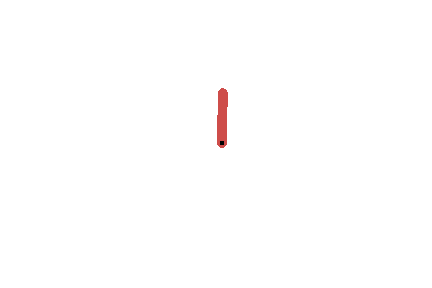
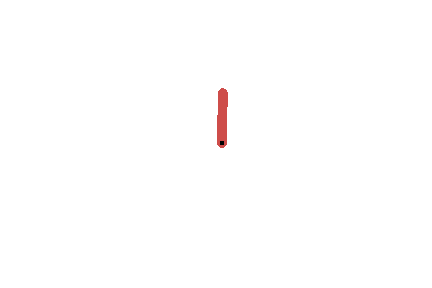
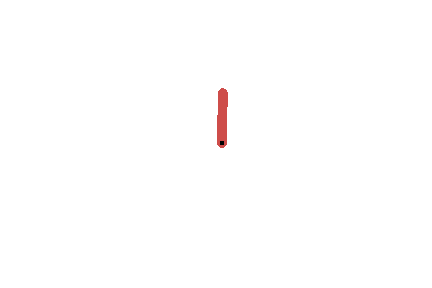
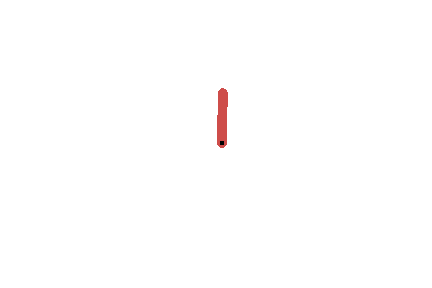
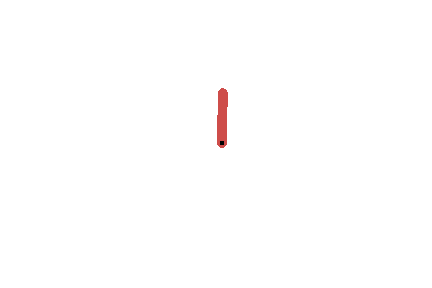
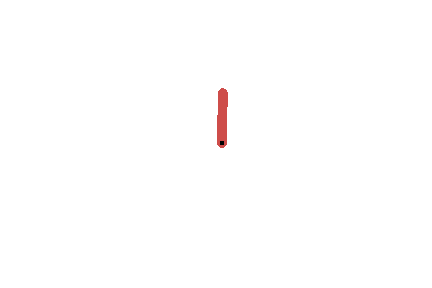
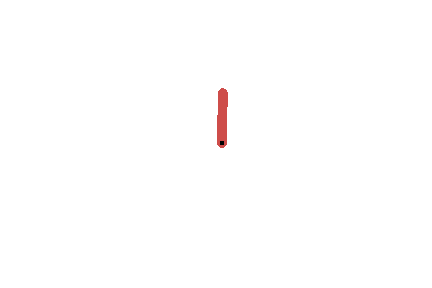
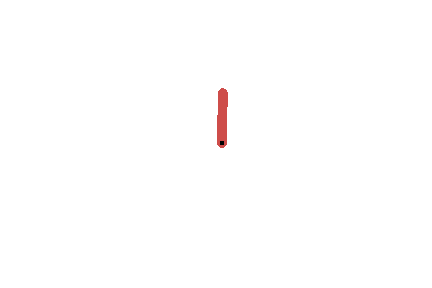
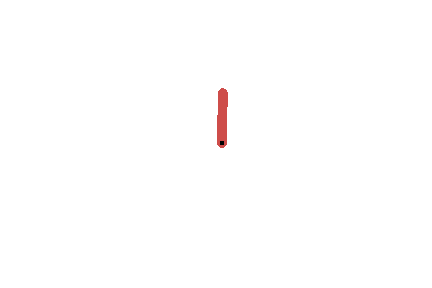
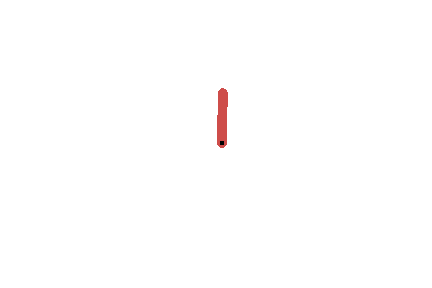
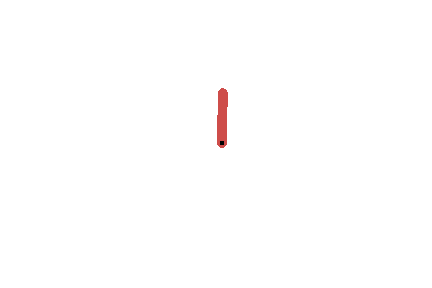
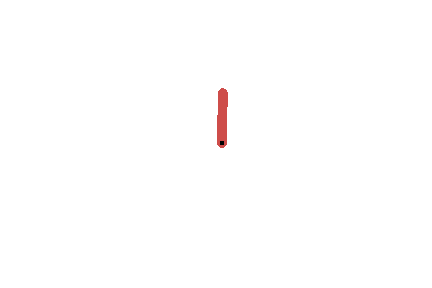
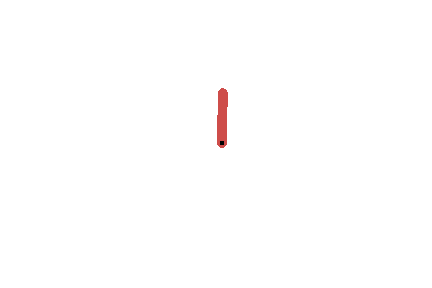
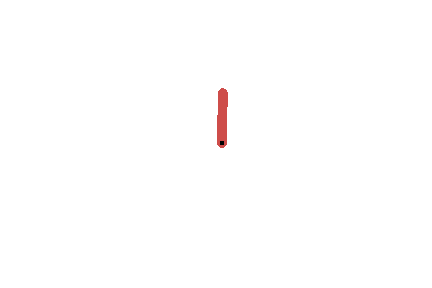
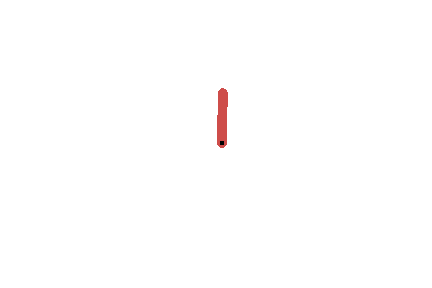
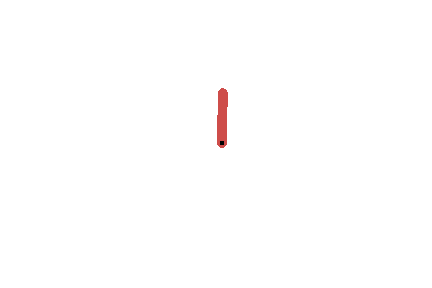
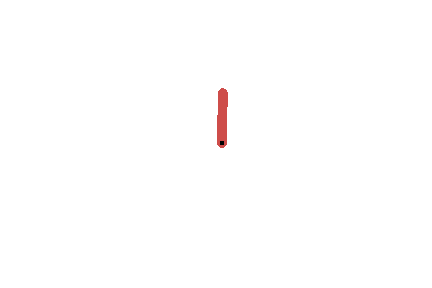
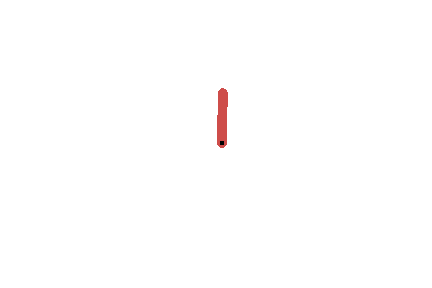
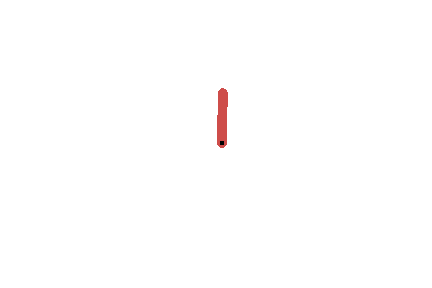
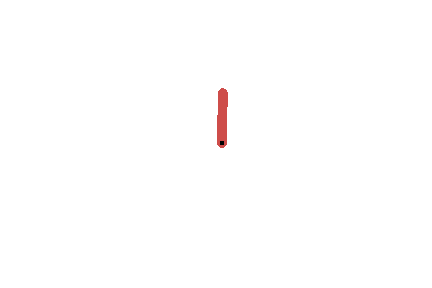
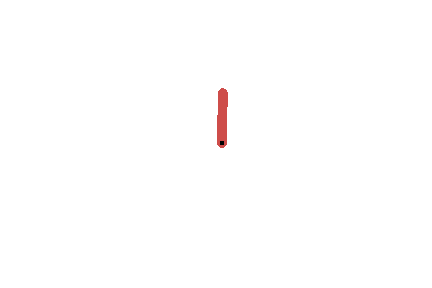
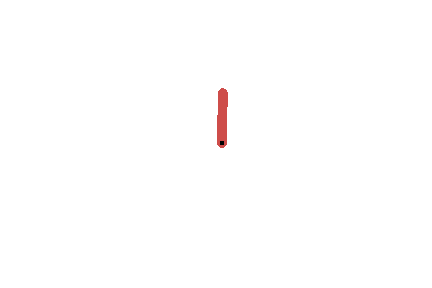
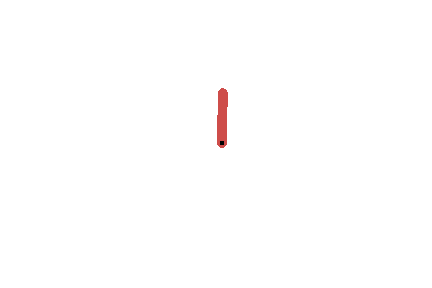
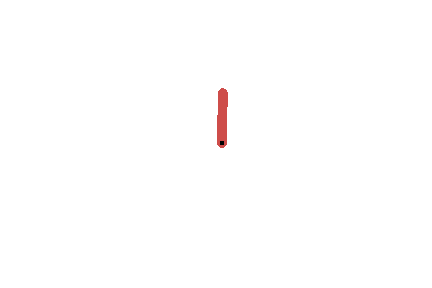
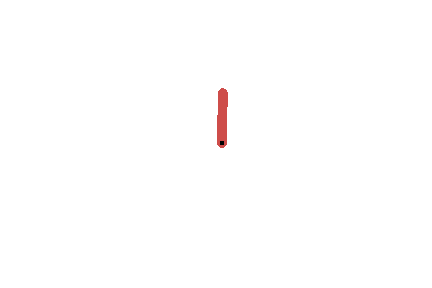
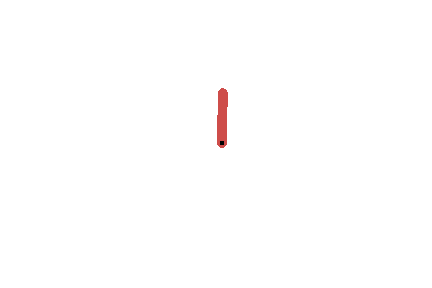
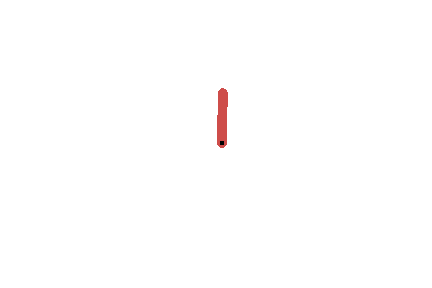
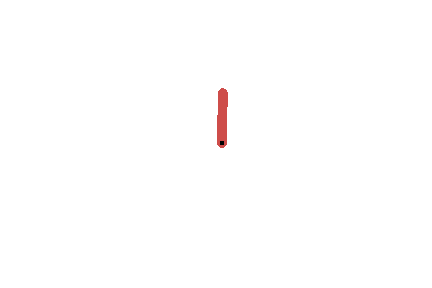
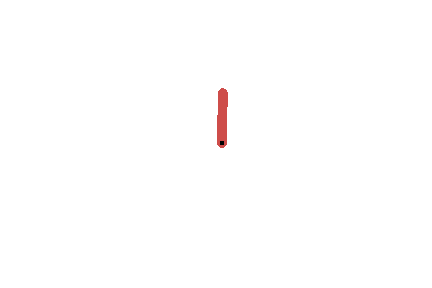
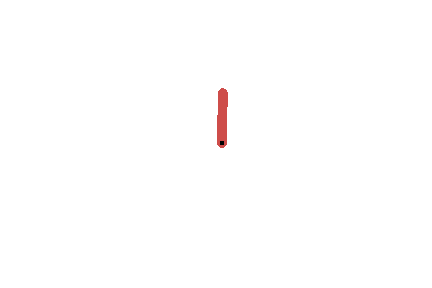
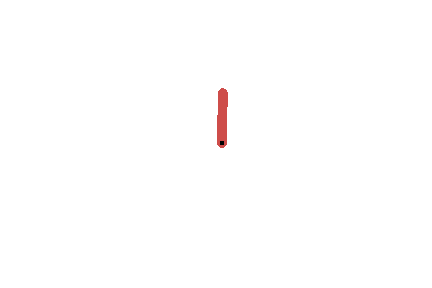
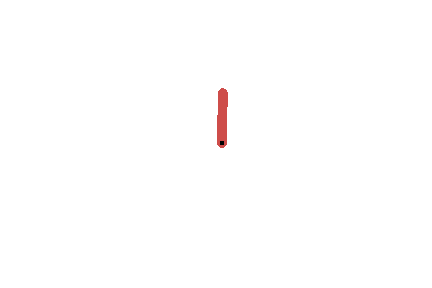
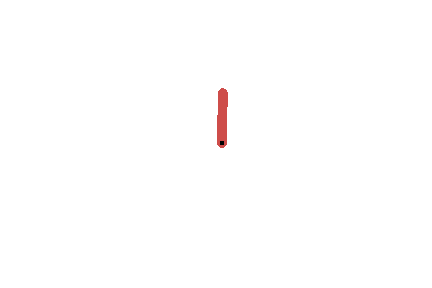
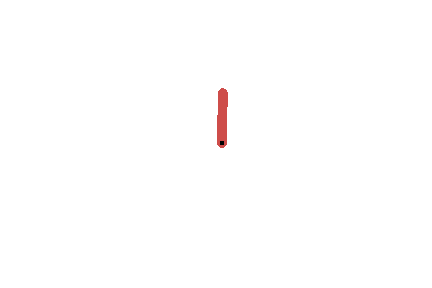
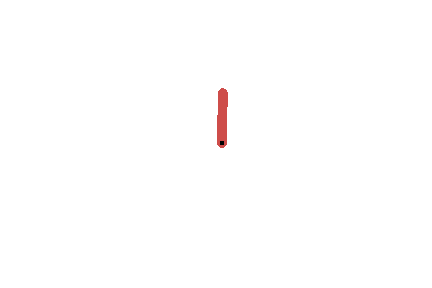
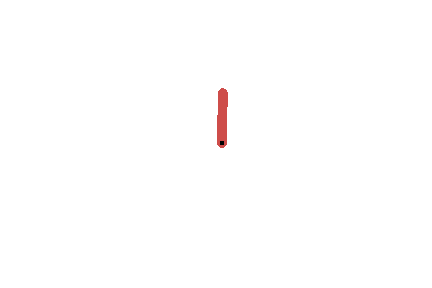
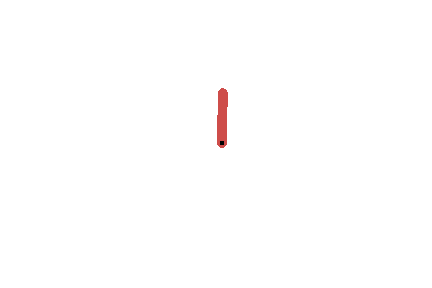
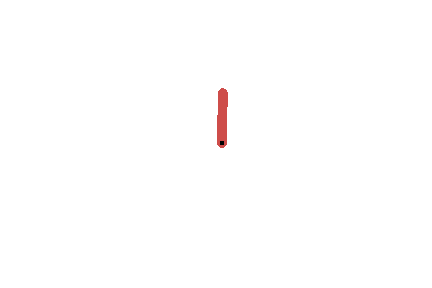
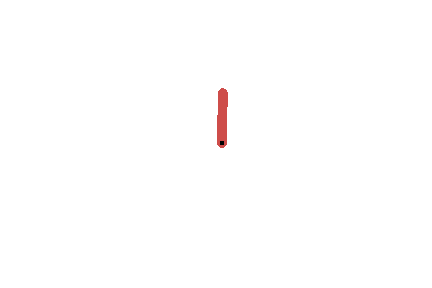
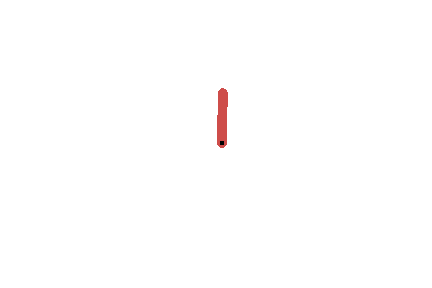
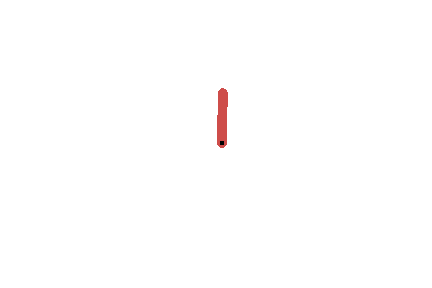
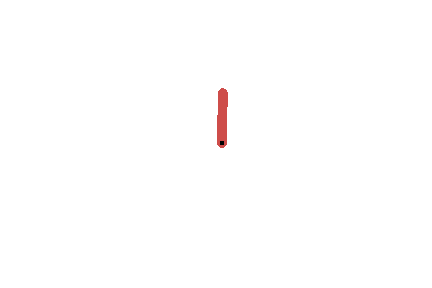
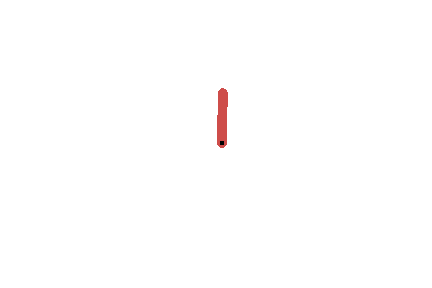
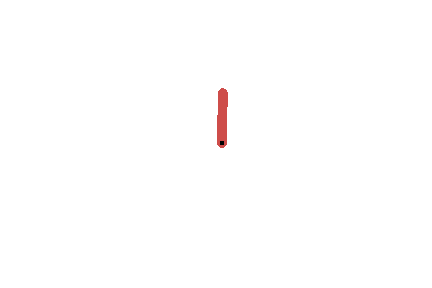
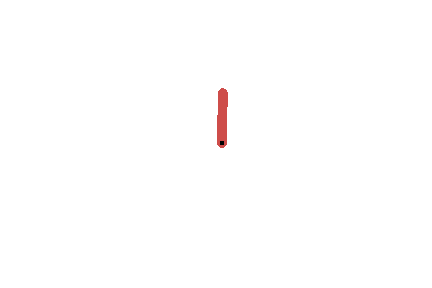
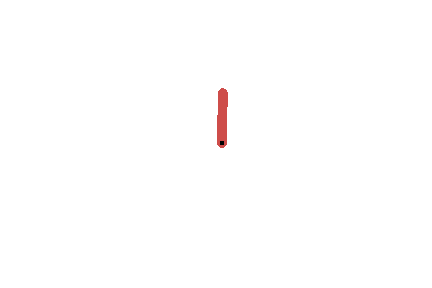
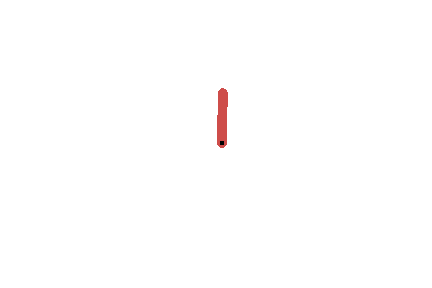
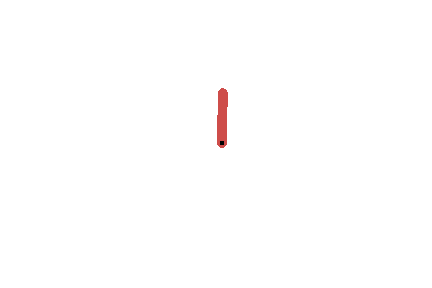
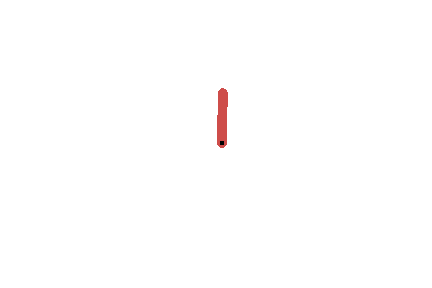
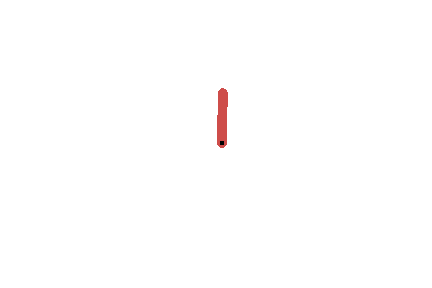
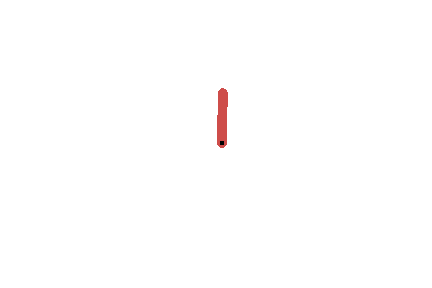
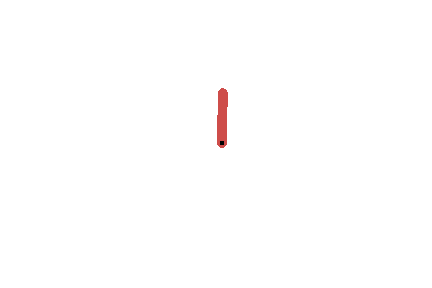
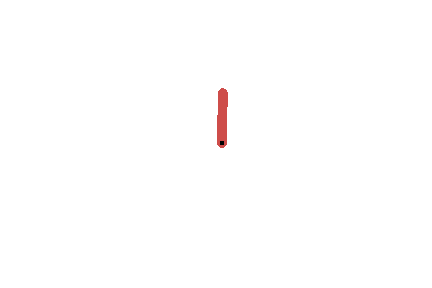
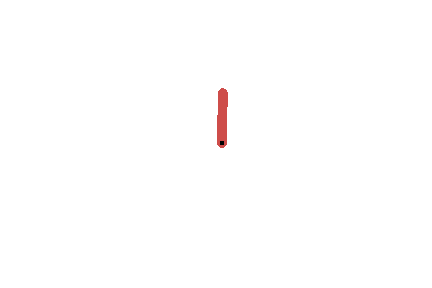
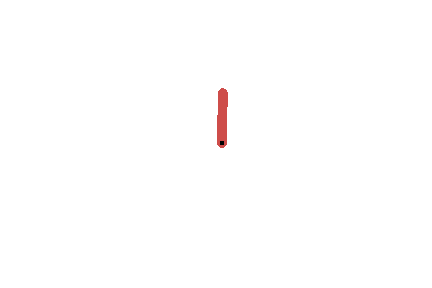
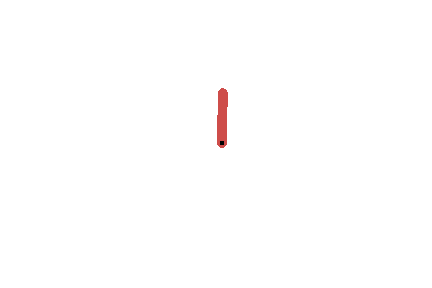
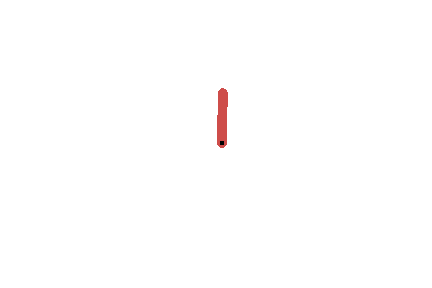
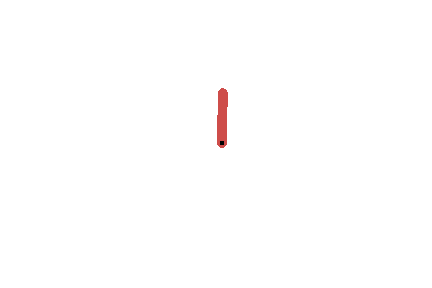
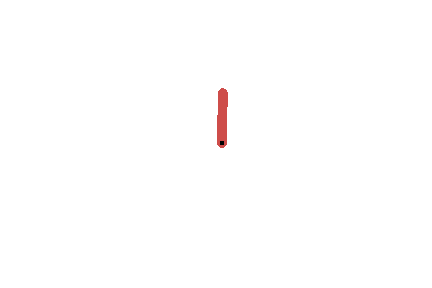
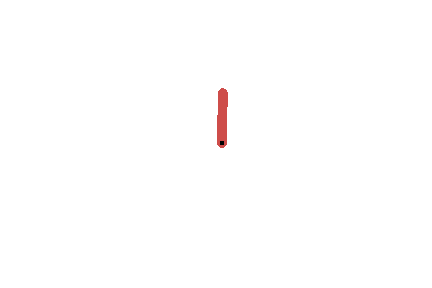
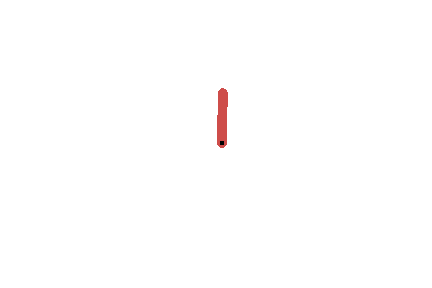
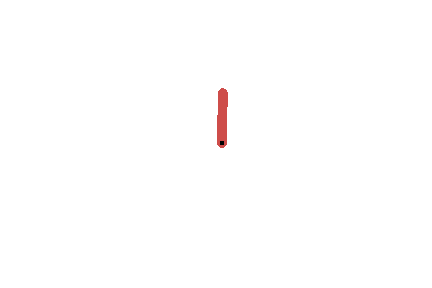
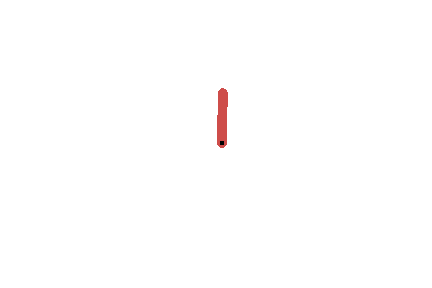
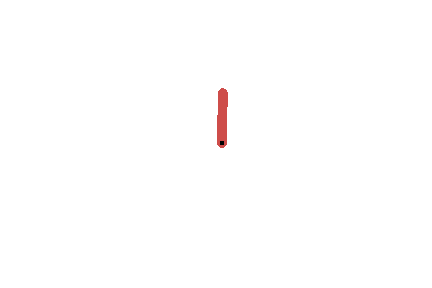
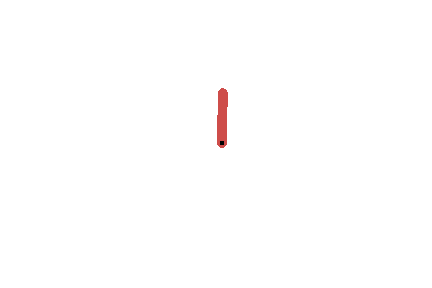
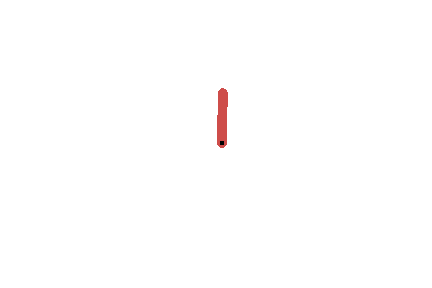
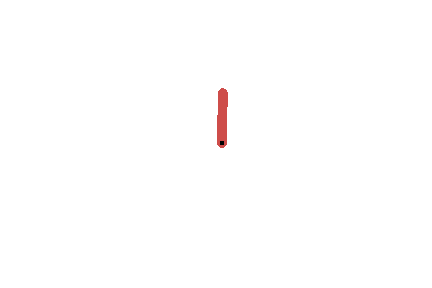
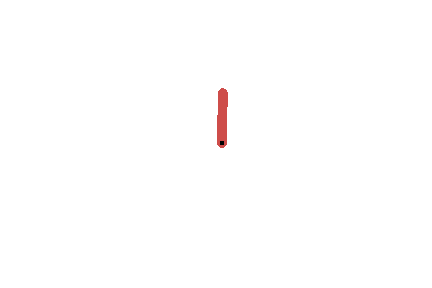
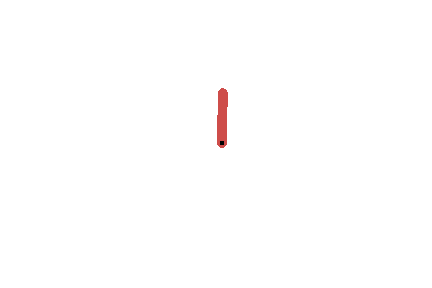
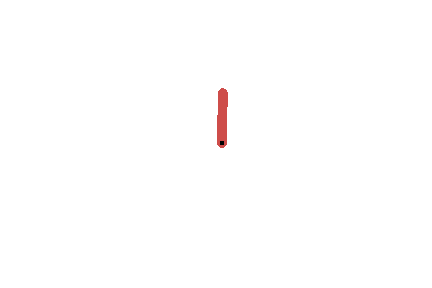
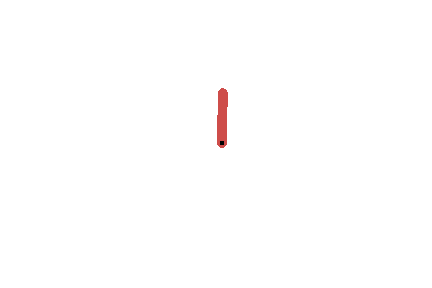
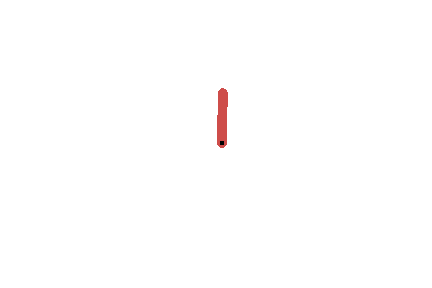
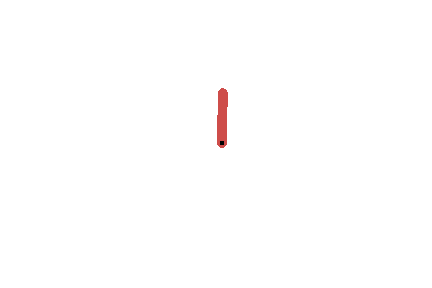
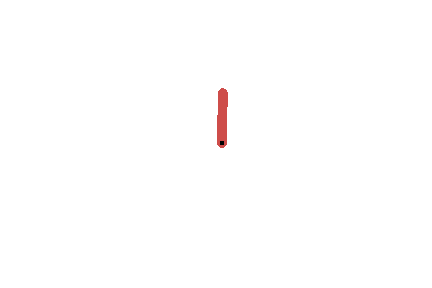
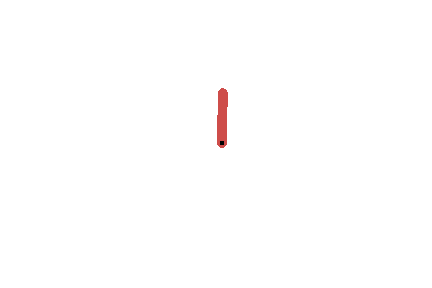
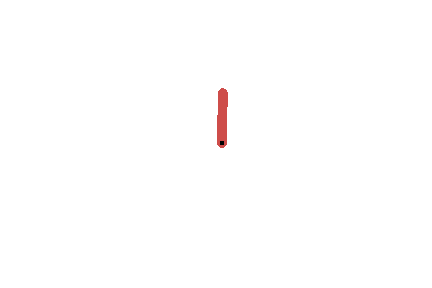
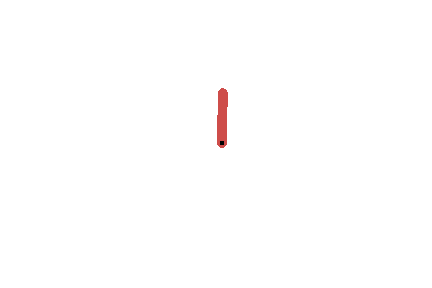
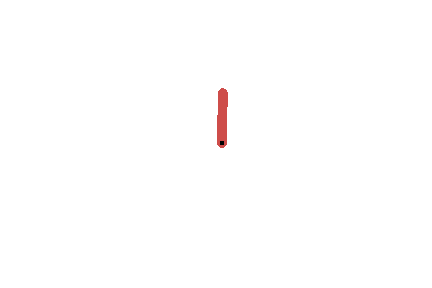
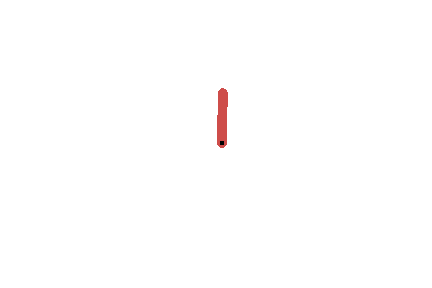
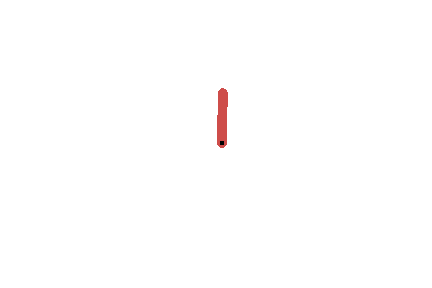
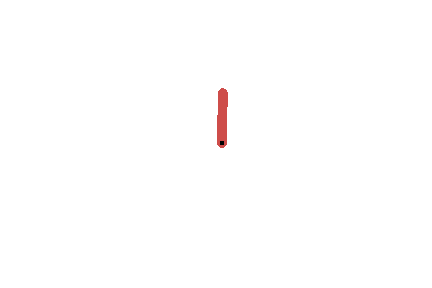
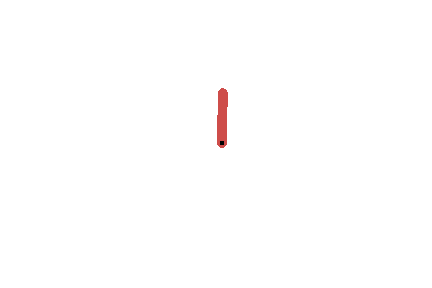
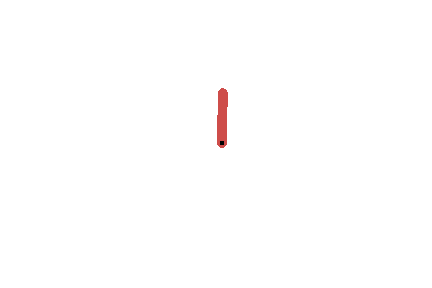
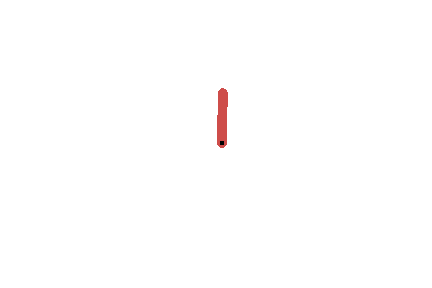
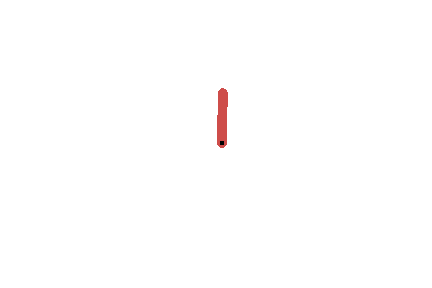
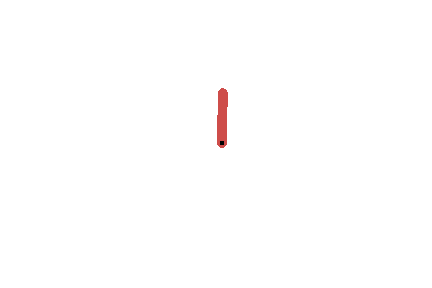
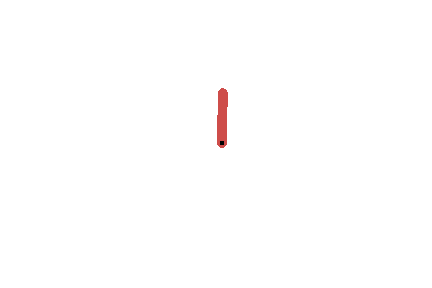
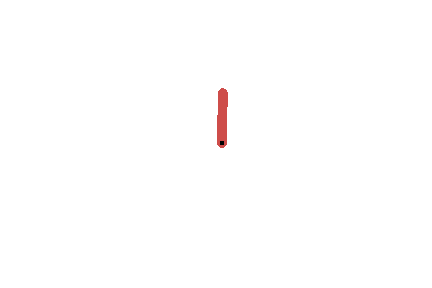

In [11]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)